In [1]:
import numpy as np

import matplotlib.pyplot as plt
from photutils.datasets import apply_poisson_noise
from astropy.modeling import models

In [2]:
np.random.seed(8675309)

In [3]:
nx = 3000
ny = 1000
const = 5
noise = 5
width = 5
center = ny / 2
x = np.arange(nx)
y = np.arange(ny)
xx, yy = np.meshgrid(x, y)
profile = models.Moffat1D()

In [4]:
profile.amplitude = 10
profile.alpha = 0.1
trace_mod = models.Chebyshev1D(degree=3, c0=0, c1=50, c2=100)
trace = yy - center + trace_mod(xx/nx)
z = const + profile(trace)
noisy = apply_poisson_noise(z)

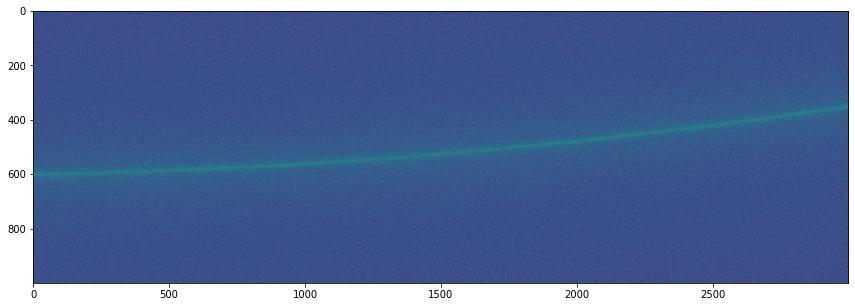

In [5]:
fig = plt.figure(figsize=(15, 5))
plt.imshow(noisy)
plt.show()

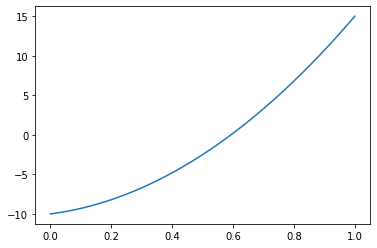

In [6]:
model = models.Chebyshev1D(degree=3, c0=0, c1=5, c2=10)
x = np.arange(3000)/3000
y = model(x)
plt.plot(x, y)

In [7]:
from specreduce.utils.synth_data import make_2dspec_image

In [8]:
im = make_2dspec_image()

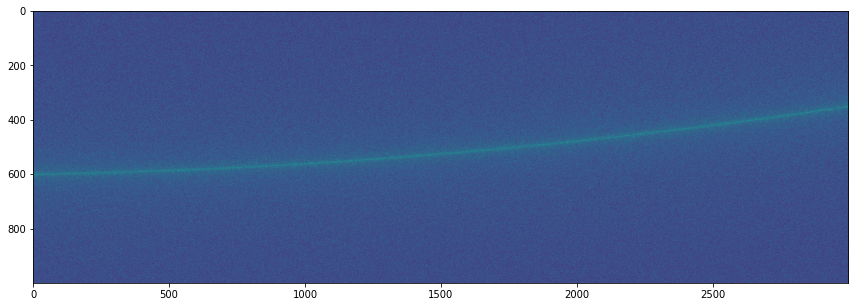

In [10]:
fig = plt.figure(figsize=(15, 5))
plt.imshow(im)